In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from geopandas.tools import geocode

import re

from datetime import datetime

from shapely.geometry import LineString, MultiPolygon, Polygon
from shapely.ops import split
from shapely.affinity import translate

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os

# 1 Load data
- df - информаци об автомобилях  
    + num - номер региона  
    + brand - бренд
    + model - модель
    + year - год выпуска
    + description - краткое описание
    + location - локация
    + price - цена
- salary  
    + num - номер региона
    + region - регион
    + median_salary - средняя ЗП (медиана)

In [2]:
DATA_DIR = os.path.join('./data/')

df = pd.read_csv(os.path.join(DATA_DIR, 'auto_mers.csv'))
salary = pd.read_csv(os.path.join(DATA_DIR, 'regions_with_salary.csv'))

rus_bnd_gdf = gpd.read_file(os.path.join(DATA_DIR, 'geo.json'))

In [3]:
salary.head()

,region,median_salary,num,Region_en,NAME_1
0,Российская Федерация,62199.7,0,NaN,NaN
1,Белгородская область,46406.6,31,Belgorod region,Belgorod
2,Брянская область,39434.4,32,Bryansk region,Bryansk
3,Владимирская область,44136.4,33,Vladimir region,Vladimir
4,Воронежская область,45142.4,36,Voronezh region,Voronezh


In [4]:
median_salary = salary.loc[0, 'median_salary']

In [5]:
df.head()

,num,brand,model,year,description,location,price
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",Майкоп,830000
1,1,Mercedes-Benz,Mercedes,1992,"2.3 л (136 л.с.), бензин, механика, задний, 22...",Майкоп,300000
2,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",Дондуковская,280000
3,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",Тахтамукай,200000
4,1,Mercedes-Benz,C-Class,2011,"1.8 л (156 л.с.), бензин, АКПП, задний, 134 ты...",Майкоп,900000


In [6]:
salary.head()

,region,median_salary,num,Region_en,NAME_1
0,Российская Федерация,62199.7,0,NaN,NaN
1,Белгородская область,46406.6,31,Belgorod region,Belgorod
2,Брянская область,39434.4,32,Bryansk region,Bryansk
3,Владимирская область,44136.4,33,Vladimir region,Vladimir
4,Воронежская область,45142.4,36,Voronezh region,Voronezh


In [7]:
rus_bnd_gdf[:5]

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
0,186,RUS,Russia,28,Karachay-Cherkess,?????????-????????? ??????????,Karaçay-Çerkes|Karachay-Cherkessiya|Karachayev...,Respublika,Republic,"POLYGON ((42.13194 44.34488, 42.19061 44.32248..."
1,186,RUS,Russia,29,Karelia,?????????? ???????,Karelian A.S.S.R.|Karelo-Finnish A.S.S.R.|Kare...,Respublika,Republic,"MULTIPOLYGON (((36.77098 64.02402, 36.75969 64..."
2,186,RUS,Russia,30,Kemerovo,??????????? ???????,Kemerovskaya Oblast,Oblast,Region,"POLYGON ((88.63731 56.77809, 88.64615 56.73922..."
3,186,RUS,Russia,31,Khabarovsk,??????????? ????,Khabarovskiy Kray,Kray,Territory,"MULTIPOLYGON (((136.64362 45.04694, 136.64417 ..."
4,186,RUS,Russia,32,Khakass,?????????? ???????,Khakassiya|Republic of Khakasia|Khakasskaya A....,Respublika,Republic,"MULTIPOLYGON (((91.45279 53.70172, 91.44386 53..."


In [8]:
df = df[df['model'] != 'Mercedes']

In [9]:
df.shape

(26814, 7)

In [10]:
salary.shape

(154, 5)

merge salary and df on 'num'

In [11]:
df = pd.merge(df, salary, on='num', how='inner')

df['flg_more_avg_salary'] = (df['median_salary'] > median_salary).astype('int')

In [12]:
df.head()

,num,brand,model,year,description,location,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",Майкоп,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
1,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",Дондуковская,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
2,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",Тахтамукай,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
3,1,Mercedes-Benz,C-Class,2011,"1.8 л (156 л.с.), бензин, АКПП, задний, 134 ты...",Майкоп,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
4,1,Mercedes-Benz,A-Class,2000,"1.6 л (102 л.с.), бензин, механика, передний, ...",Хатукай,250000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0


In [13]:
df.shape

(26814, 12)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26814 entries, 0 to 26813
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   num                  26814 non-null  int64  
 1   brand                26814 non-null  object 
 2   model                26814 non-null  object 
 3   year                 26814 non-null  int64  
 4   description          26814 non-null  object 
 5   location             26814 non-null  object 
 6   price                26814 non-null  int64  
 7   region               26814 non-null  object 
 8   median_salary        26814 non-null  float64
 9   Region_en            26814 non-null  object 
 10  NAME_1               26814 non-null  object 
 11  flg_more_avg_salary  26814 non-null  int32  
dtypes: float64(1), int32(1), int64(3), object(7)
memory usage: 2.6+ MB


In [15]:
df.describe()

,num,year,price,median_salary,flg_more_avg_salary
count,26814.000000,26814.000000,2.681400e+04,26814.000000,26814.000000
mean,48.268703,2010.324457,2.826853e+06,59158.197285,0.272097
std,25.398777,8.173165,4.147156e+06,22507.835182,0.445048
min,1.000000,1940.000000,2.500000e+04,31348.600000,0.000000
25%,25.000000,2005.000000,7.950000e+05,44670.500000,0.000000
50%,50.000000,2012.000000,1.568950e+06,50292.800000,0.000000
75%,72.000000,2017.000000,3.190000e+06,62201.700000,1.000000
max,102.000000,2022.000000,9.500000e+07,136166.900000,1.000000


In [16]:
df.describe(include='object')

,brand,model,description,location,region,Region_en,NAME_1
count,26814,26814,26814,26814,26814,26814,26814
unique,1,41,10906,1236,82,82,82
top,Mercedes-Benz,E-Class,"2.9 л (330 л.с.), дизель, АКПП, 4WD",Москва,Москва,Moscow,Moscow City
freq,26814,6544,98,2130,2130,2130,2130


# 2 Exploratory data analysis

## 2.1 Feature engineering

Анализ целеовой переменной

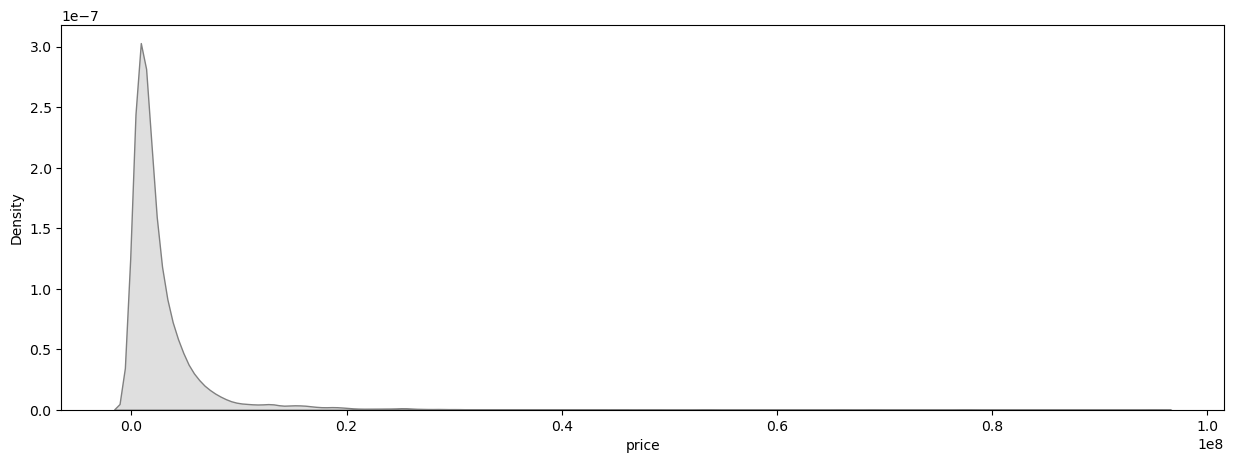

In [17]:
plt.figure(figsize=(15, 5))
sns.kdeplot(df['price'], fill=True, color='grey')
plt.show();

 Большой хвост из-за дорогих моделей, при выборе функции потерь в модели ML это стоит учесть

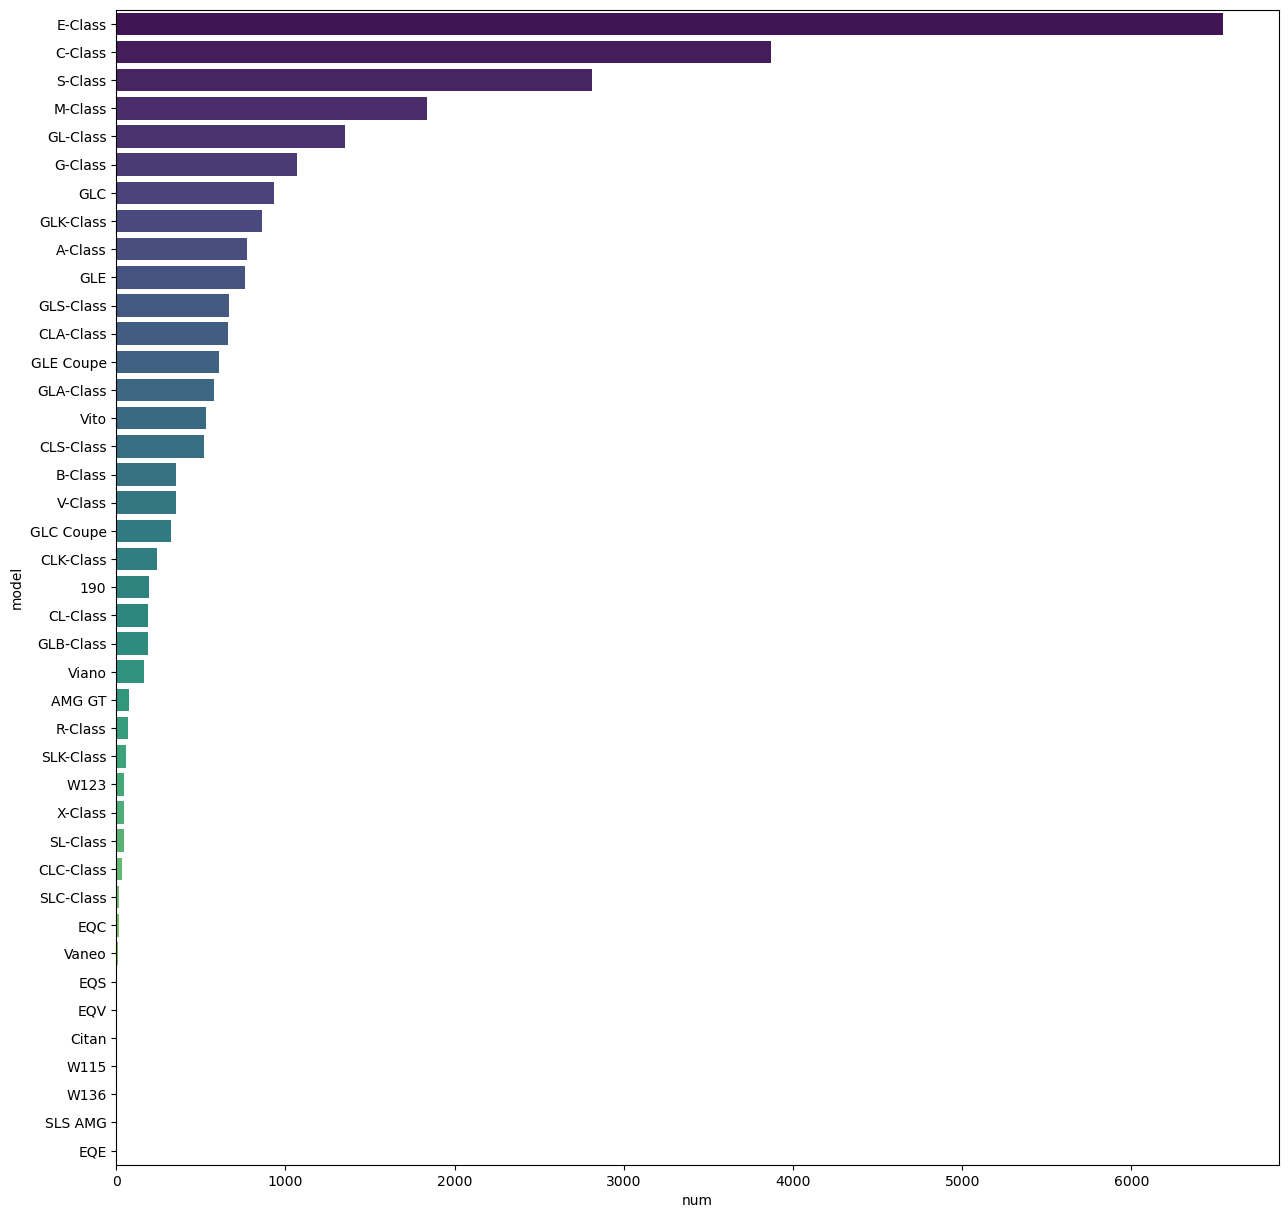

In [18]:
plt.figure(figsize=(15, 15))
sns.barplot(data=df.groupby('model')[['num']].count().reset_index().sort_values('num', ascending=False),
           y='model',
           x='num',
           palette='viridis')
plt.show();

Удаляем модели авто, которых выставленно на продажу не много

In [19]:
groups_count = df.model.value_counts()
drop_models = groups_count[groups_count <= 15].index

df = df[~df.model.isin(drop_models)]

In [20]:
df.shape

(26769, 12)

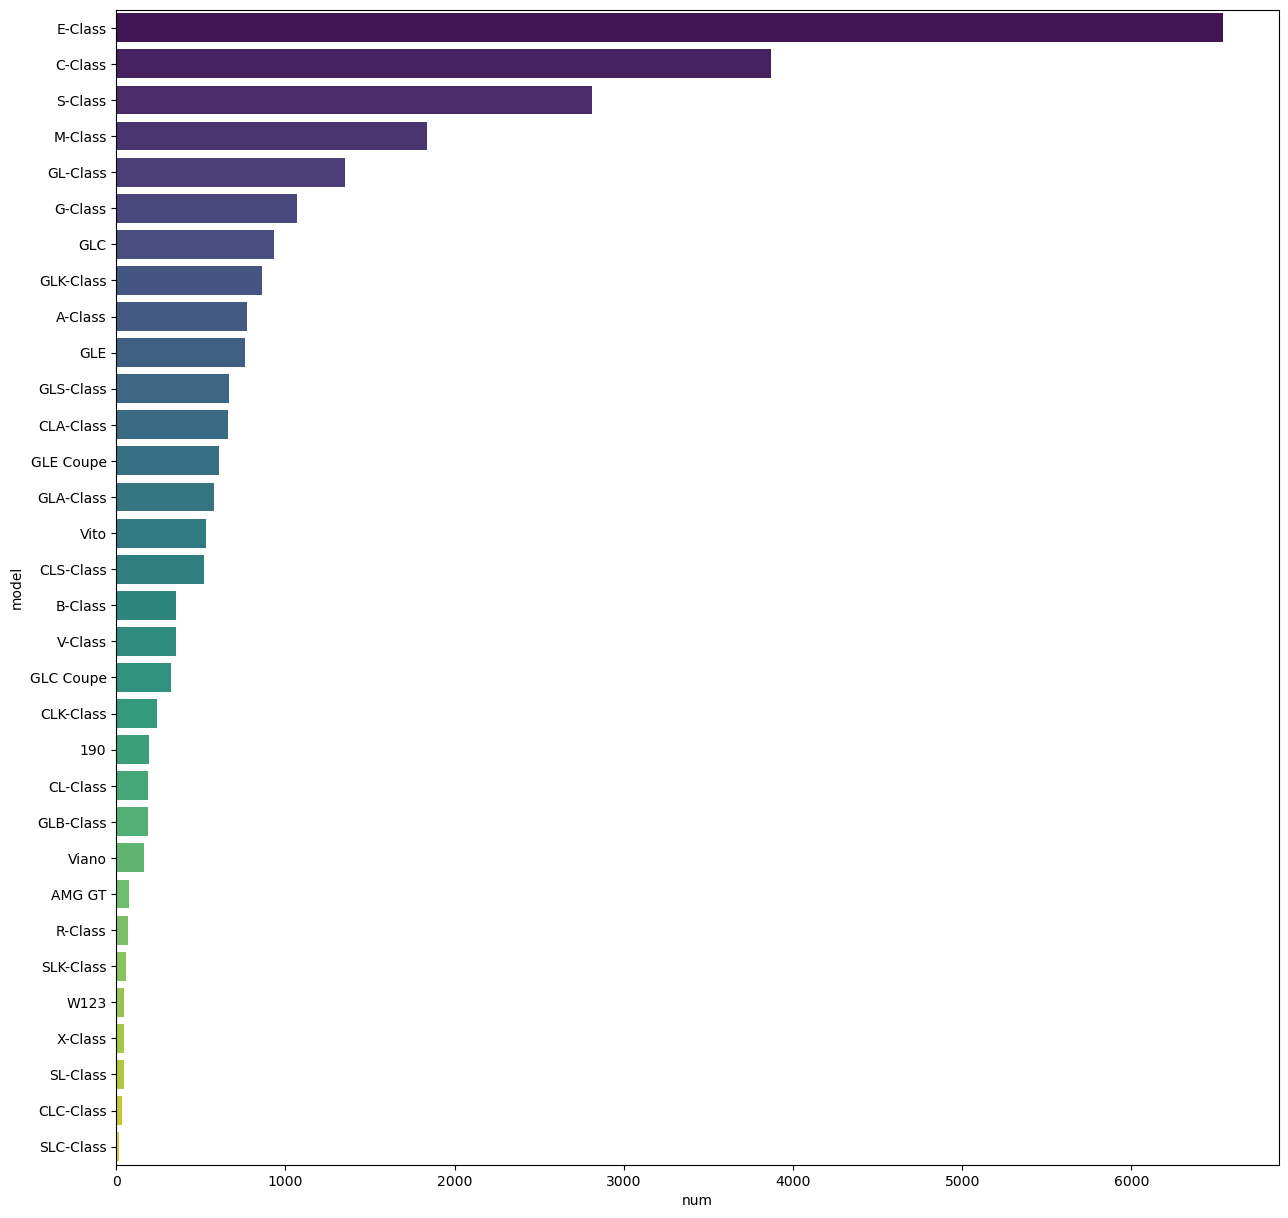

In [21]:
plt.figure(figsize=(15, 15))
sns.barplot(data=df.groupby('model')[['num']].count().reset_index().sort_values('num', ascending=False),
           y='model',
           x='num',
           palette='viridis')
plt.show();

Добавим признак возраста

In [22]:
df['age'] = [datetime.now().year] - df['year']

Почистим некоторые из значений признаков

In [23]:
df[df.region == 'Республика Адыгея'].groupby('location')[['price']].median()

,price
location,
Апшеронск (≈ 50 км),950000.0
Белореченск (≈ 30 км),950000.0
Дондуковская,280000.0
Лабинск (≈ 60 км),1200000.0
Майкоп,1015000.0
Тахтамукай,300000.0
Хадыженск (≈ 70 км),600000.0
Ханская,1700000.0
Хатукай,250000.0


In [24]:
df[df.region == 'Республика Адыгея'].groupby('location')[['price']].count()

,price
location,
Апшеронск (≈ 50 км),2
Белореченск (≈ 30 км),27
Дондуковская,3
Лабинск (≈ 60 км),12
Майкоп,22
Тахтамукай,4
Хадыженск (≈ 70 км),5
Ханская,2
Хатукай,2


In [25]:
df.drop('location', axis=1, inplace=True)

Дропаем города и оставлям только регион страны, чтобы у модели была обобщающая способность

In [26]:
df[:5]

,num,brand,model,year,description,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,17
1,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,24
2,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,32
3,1,Mercedes-Benz,C-Class,2011,"1.8 л (156 л.с.), бензин, АКПП, задний, 134 ты...",900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,12
4,1,Mercedes-Benz,A-Class,2000,"1.6 л (102 л.с.), бензин, механика, передний, ...",250000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23


Преобразуем гео информацию для отображении на картах, также добавим среднюю зарплату

In [27]:
# https://stackoverflow.com/questions/66833670/geopandas-map-centering-with-countries

In [28]:
russia_salary_geo = gpd.GeoDataFrame(
    pd.merge(salary,
             rus_bnd_gdf[['NAME_1', 'geometry']],
             on='NAME_1',
             how='left'))

In [29]:
russia_salary_geo[:2]

,region,median_salary,num,Region_en,NAME_1,geometry
0,Российская Федерация,62199.7,0,NaN,NaN,None
1,Белгородская область,46406.6,31,Belgorod region,Belgorod,"POLYGON ((38.10826 51.38651, 38.14936 51.35922..."


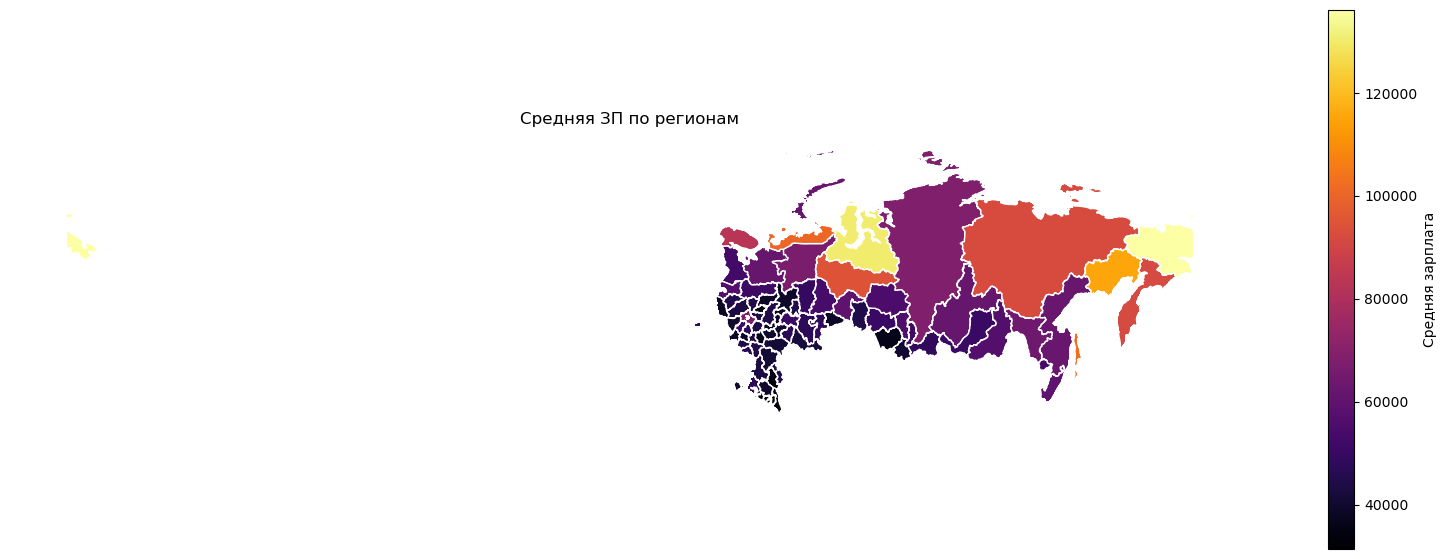

In [30]:
colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

mo_gdf_wm = russia_salary_geo.to_crs({'init':
                                      'epsg:4326'})  # преобразование проекции
mo_gdf_wm.plot(column='median_salary',
               linewidth=1,
               cmap=colors[2],
               legend=True,
               figsize=[20, 7],
               legend_kwds={
                   'label': "Средняя зарплата",
                   'orientation': "vertical"
               },
               edgecolor="white",
               aspect='auto')
plt.title('Средняя ЗП по регионам')
plt.axis('off')
plt.show();

Наиболее высокие ЗП в северных и удаленных регионах, в Москве и Санкт-Петербурге

Распарсим description по полям

In [31]:
def parsing_desc(data: str) -> list:
    try:
        if 'тыс. км' not in data:
            data += ', 0 тыс. км'
        
        lst = data.split(', ')
        ltr, type_engine, transm, machine_drive, mileage, *_ = lst
        
        liters = float(ltr.split()[0])
        horsepower = int(re.sub(r'[^\d]', '', ltr.split()[2]))
        mileage = int(re.sub(r'[^\d]', '', mileage))
        mileage = 0 if mileage == 1 else mileage
        
        return [liters, horsepower, type_engine, transm, machine_drive, mileage]
    except:
        return None
        

In [32]:
df['full_desc'] = df['description'].transform(lambda x: parsing_desc(x))

In [33]:
df_parse = df['full_desc'].apply(pd.Series)
df_parse.columns = ['liters', 'horse_power', 'type_engine', 'transmission', 'machine_drive', 'mileage']

df = pd.concat([df.drop(['description', 'full_desc'], axis=1), df_parse], axis=1)

In [34]:
df[:3]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,17,3.2,204.0,дизель,АКПП,задний,350.0
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,24,2.8,193.0,бензин,автомат,задний,360.0
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,32,3.0,220.0,бензин,АКПП,задний,352.0


In [35]:
df[(df.mileage == 0) & (df.age > 2)][:2]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
23,1,Mercedes-Benz,E-Class,1993,500000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,30,3.0,136.0,дизель,механика,задний,0.0
32,1,Mercedes-Benz,CLK-Class,2002,600000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,21,2.6,170.0,бензин,АКПП,задний,0.0


In [36]:
df[(df.mileage < 2) & (df.age > 2)][:2]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
23,1,Mercedes-Benz,E-Class,1993,500000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,30,3.0,136.0,дизель,механика,задний,0.0
32,1,Mercedes-Benz,CLK-Class,2002,600000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,21,2.6,170.0,бензин,АКПП,задний,0.0


Имеются иашины с нулевым пробегом, ошибка в данных, поэтому необходима очистка

In [37]:
index_drop = df[(df.mileage < 2) & (df.age > 2)].index
df = df[~df.index.isin(index_drop)]

In [38]:
df.isna().sum()

num                      0
brand                    0
model                    0
year                     0
price                    0
region                   0
median_salary            0
Region_en                0
NAME_1                   0
flg_more_avg_salary      0
age                      0
liters                 273
horse_power            273
type_engine            273
transmission           273
machine_drive          273
mileage                273
dtype: int64

In [39]:
df.describe()

,num,year,price,median_salary,flg_more_avg_salary,age,liters,horse_power,mileage
count,26129.000000,26129.00000,2.612900e+04,26129.000000,26129.000000,26129.00000,25856.000000,25856.000000,25856.000000
mean,48.543113,2010.47453,2.849135e+06,59370.772479,0.275479,12.52547,2.777139,236.889194,164.608563
std,25.316655,8.08935,4.115164e+06,22530.770521,0.446764,8.08935,1.134914,102.422825,115.770275
min,1.000000,1960.00000,2.500000e+04,31348.600000,0.000000,1.00000,0.400000,38.000000,0.000000
25%,25.000000,2006.00000,8.000000e+05,45025.700000,0.000000,6.00000,2.000000,163.000000,78.000000
50%,50.000000,2012.00000,1.600000e+06,50292.800000,0.000000,11.00000,2.300000,211.000000,150.000000
75%,72.000000,2017.00000,3.200000e+06,63730.800000,1.000000,17.00000,3.200000,272.000000,230.000000
max,102.000000,2022.00000,7.760700e+07,136166.900000,1.000000,63.00000,6.500000,700.000000,1000.000000


In [40]:
df.describe(include='object')

,brand,model,region,Region_en,NAME_1,type_engine,transmission,machine_drive
count,26129,26129,26129,26129,26129,25856,25856,25856
unique,1,32,82,82,82,3,5,3
top,Mercedes-Benz,E-Class,Москва,Moscow,Moscow City,бензин,АКПП,4WD
freq,26129,6323,2104,2104,2104,19353,20307,13111


In [41]:
df.shape

(26129, 17)

In [42]:
df[df.liters < 1.0]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
8118,25,Mercedes-Benz,S-Class,2007,1700000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,16,0.5,388.0,бензин,автомат,4WD,10.0
22965,77,Mercedes-Benz,G-Class,2022,23000000,Москва,114700.7,Moscow,Moscow City,1,1,0.4,422.0,бензин,автомат,4WD,0.0


In [43]:
df.query("model.str.contains('S-Class') and year==2007 and horse_power==388",
         engine="python")[:2]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
25,1,Mercedes-Benz,S-Class,2007,1050000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,5.5,388.0,бензин,АКПП,4WD,184.0
63,1,Mercedes-Benz,S-Class,2007,1050000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,5.5,388.0,бензин,АКПП,4WD,184.0


In [44]:
df.query("model.str.contains('G-Class') and year==2022",
         engine="python")[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
5615,23,Mercedes-Benz,G-Class,2022,27900000,Краснодарский край,47231.8,Krasnodar region,Krasnodar,0,1,4.0,585.0,бензин,АКПП,4WD,0.0
7223,25,Mercedes-Benz,G-Class,2022,27000000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,1,4.0,585.0,бензин,АКПП,4WD,0.0
7305,25,Mercedes-Benz,G-Class,2022,26500000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,1,4.0,585.0,бензин,АКПП,4WD,0.0
7349,25,Mercedes-Benz,G-Class,2022,27000000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,1,4.0,585.0,бензин,АКПП,4WD,0.0


In [45]:
df.loc[8118, 'liters'] = 5.5
df.loc[22965, 'liters'] = 4.0

Есть пропуски, заполняем пропуски похожими значениями

In [46]:
for col in ['liters', 'horse_power', 'type_engine', 'transmission', 'machine_drive', 'mileage']:
    df[col] = df.groupby(['model', 'year'])[col].apply(lambda x: x.fillna(x.mode(dropna=False)[0]))

In [47]:
df.isna().sum()

num                     0
brand                   0
model                   0
year                    0
price                   0
region                  0
median_salary           0
Region_en               0
NAME_1                  0
flg_more_avg_salary     0
age                     0
liters                  8
horse_power             8
type_engine             8
transmission            8
machine_drive           8
mileage                61
dtype: int64

In [48]:
df.dropna(inplace=True)

In [49]:
df.shape

(26068, 17)

Добавим флаг нового автомобиля

In [50]:
df['flg_new_auto'] = (df.mileage == 0).astype(int)

In [51]:
df['flg_new_auto'].value_counts()

0    24926
1     1142
Name: flg_new_auto, dtype: int64

Проверим типы коробок передач

In [52]:
df.transmission.value_counts()

АКПП        20480
робот        1924
механика     1820
автомат      1594
вариатор      250
Name: transmission, dtype: int64

АКПП в целом довольно общее понятие, для простоты заменим его на автомат

In [53]:
df['transmission'] = df['transmission'].replace('АКПП', 'автомат')

In [54]:
df.transmission.value_counts()

автомат     22074
робот        1924
механика     1820
вариатор      250
Name: transmission, dtype: int64

Новый признак - тип кузова

In [55]:
body_type = {
    'Хэтчбэк': ['A-Class', 'B-Class'],
    'Седан': ['E-Class', 'C-Class', 'S-Class', '190', 'W123'],
    'Внедорожники': [
        'X-Class', 'M-Class', 'GLC', 'GLA-Class', 'GLB-Class', 'GLS-Class',
        'GLE', 'GL-Class', 'GLK-Class', 'G-Class'
    ],
    'Купэ': ['CLA-Class', 'CLS-Class', 'AMG GT', 'CL-Class', 'CLC-Class'],
    'Родстеры/кабриолеты': ['SL-Class', 'SLC-Class', 'CLK-Class', 'SLK-Class'],
    'Минивэн': ['Vito', 'Viano', 'V-Class', 'R-Class'],
    'Кроссовер': ['GLE Coupe', 'GLC Coupe'],
}

reverse_body_type = {x: k for k, v in body_type.items() for x in v}

In [56]:
df['body_type'] = df.model.map(reverse_body_type)

In [57]:
df[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,flg_new_auto,body_type
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,17,3.2,204.0,дизель,автомат,задний,350.0,0,Седан
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,24,2.8,193.0,бензин,автомат,задний,360.0,0,Седан
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,32,3.0,220.0,бензин,автомат,задний,352.0,0,Седан
3,1,Mercedes-Benz,C-Class,2011,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,12,1.8,156.0,бензин,автомат,задний,134.0,0,Седан


In [58]:
def plot_auto_geo(data: pd.DataFrame,
                  geo_data: gpd.GeoDataFrame,
                  title: str,
                  cmap: str = 'Spectral_r',
                  agg_col: str = 'price',
                  func: str = 'mean',
                  group_col: str = 'NAME_1',
                  ax=None):
    """Отображение на карте агрегированных данных"""

    agg_data = data.groupby(group_col)[agg_col].agg(func)
    auto_geo = gpd.GeoDataFrame(
        pd.merge(agg_data, geo_data, on=group_col, how='left'))

    mo_gdf_wm = auto_geo.to_crs({'init': 'epsg:4326'})
    mo_gdf_wm.plot(column=agg_col,
                   linewidth=0.5,
                   cmap=cmap,
                   legend=True,
                   figsize=[20, 7],
                   legend_kwds={
                       'label': func,
                       'orientation': "vertical"
                   },
                   edgecolor="white",
                   vmin=agg_data.min(),
                   vmax=agg_data.max(),
                   ax=ax,
                   aspect='auto')
    if ax:
        ax.set_title(title, fontdict={'fontsize': 14})
    else:
        plt.title(title, fontdict={'fontsize': 16})
        plt.axis('off')
        plt.show()

# 3 Hypothese

### В регионах с ЗП выше средней по России стоимость авто больше

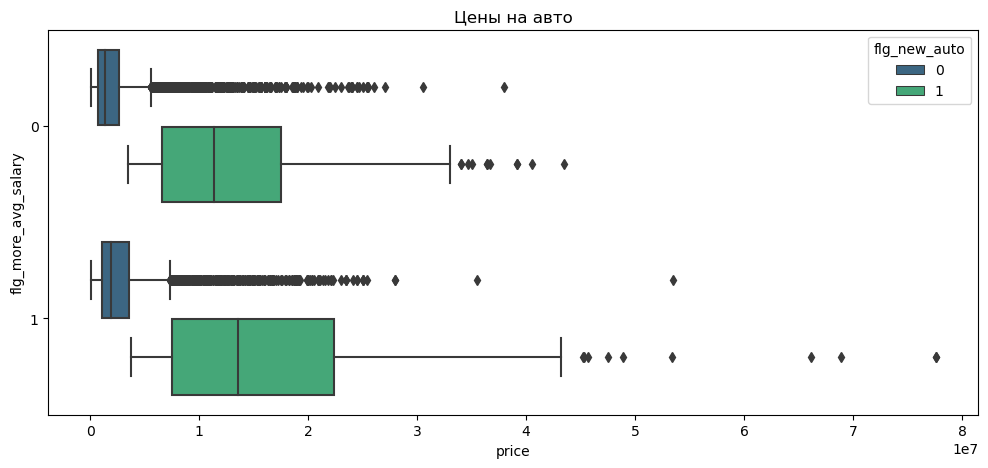

In [59]:
plt.figure(figsize=(12, 5))

sns.boxplot(data=df,
           x='price',
           y='flg_more_avg_salary',
           hue='flg_new_auto',
           orient='h',
           palette='viridis')
plt.title('Цены на авто')
plt.show()

> Ориентируемся по медианам. В регионах с ЗП выше средней стоимость новых машин выше. Можно предположить, что в данных регионах продаются элитные модели.

### Цены машин коррелируют со средней зарплатой в регионе

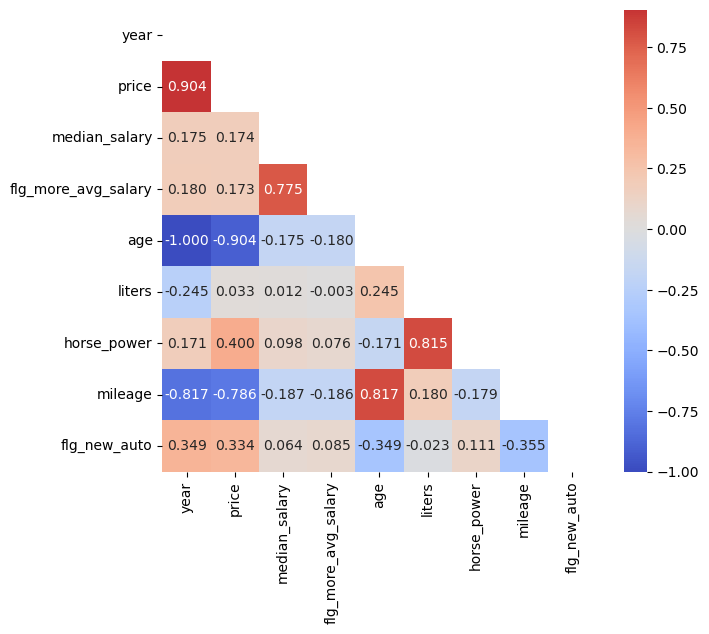

In [60]:
mask = np.triu(df.iloc[:, 1:].corr(method='spearman')).astype(bool)

plt.figure(figsize=(7, 6))

sns.heatmap(df.iloc[:, 1:].corr(method='spearman'),
           annot=True,
           fmt='.3f',
           center=0,
           cmap='coolwarm',
           mask=mask)
plt.show()

> Цена выше у более новых машин. Больше пробег и возраст, цена ниже. Очевидные факты.

### Различия в цене в разрезе типа двигателя, трансмиссии, привода

In [61]:
price_df = df[['type_engine', 'transmission', 'machine_drive',
               'price']].melt(id_vars=['price'])

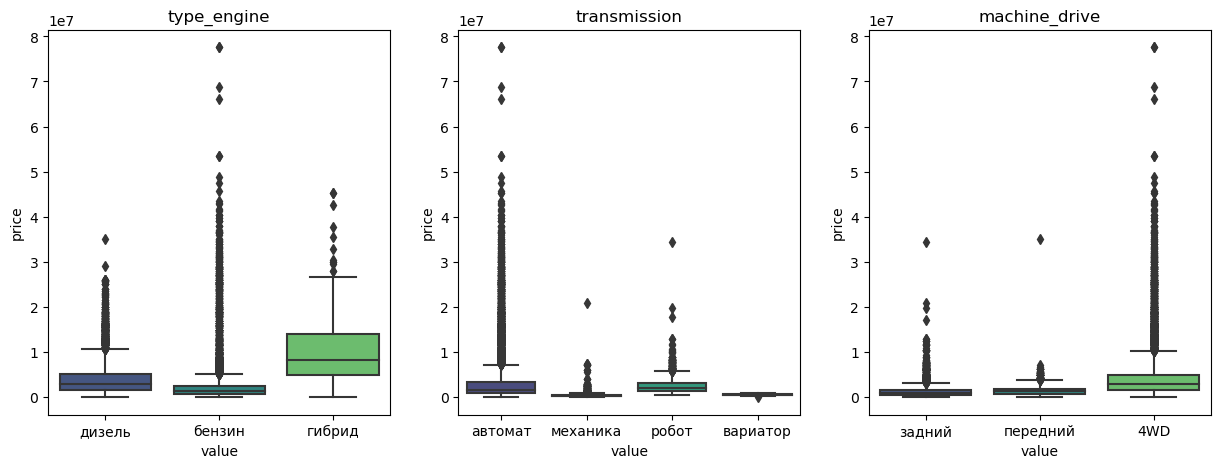

In [62]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for num, val in enumerate(price_df.variable.unique()):
    sns.boxplot(data=price_df[price_df.variable == val],
               y='price',
               x='value',
               palette=colors[0],
               ax=axes[num]).set_title(val)

plt.show()

> Гибрид самый дорогой вид двигателя

> Автомат и робот дороже других

> Полноприводные более дорогие

Выводы очевидные

### Взаимосвязь стоимости авто и средней зарплаты в регионе

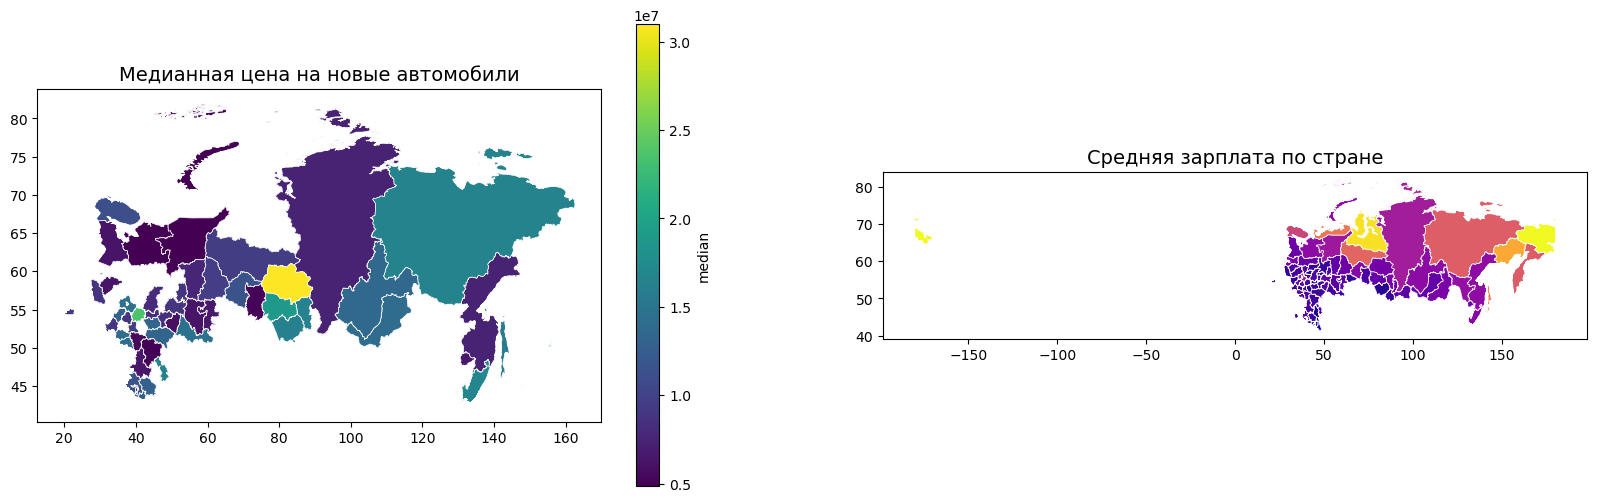

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

plot_auto_geo(data=df[df.flg_new_auto == 1],
              geo_data=russia_salary_geo,
              title='Медианная цена на новые автомобили',
              cmap=colors[0],
              agg_col='price',
              func='median',
              group_col='NAME_1',
              ax=axes[0])

mo_gdf_wm = russia_salary_geo.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='median_salary',
               linewidth=0.5,
               cmap=colors[1],
               legend_kwds={
                   'label': "median salary",
                   'orientation': "vertical"
               },
               edgecolor="white",
               ax=axes[1],
               aspect='auto')
axes[1].set_title('Средняя зарплата по стране', fontdict={'fontsize': 14})
plt.show()

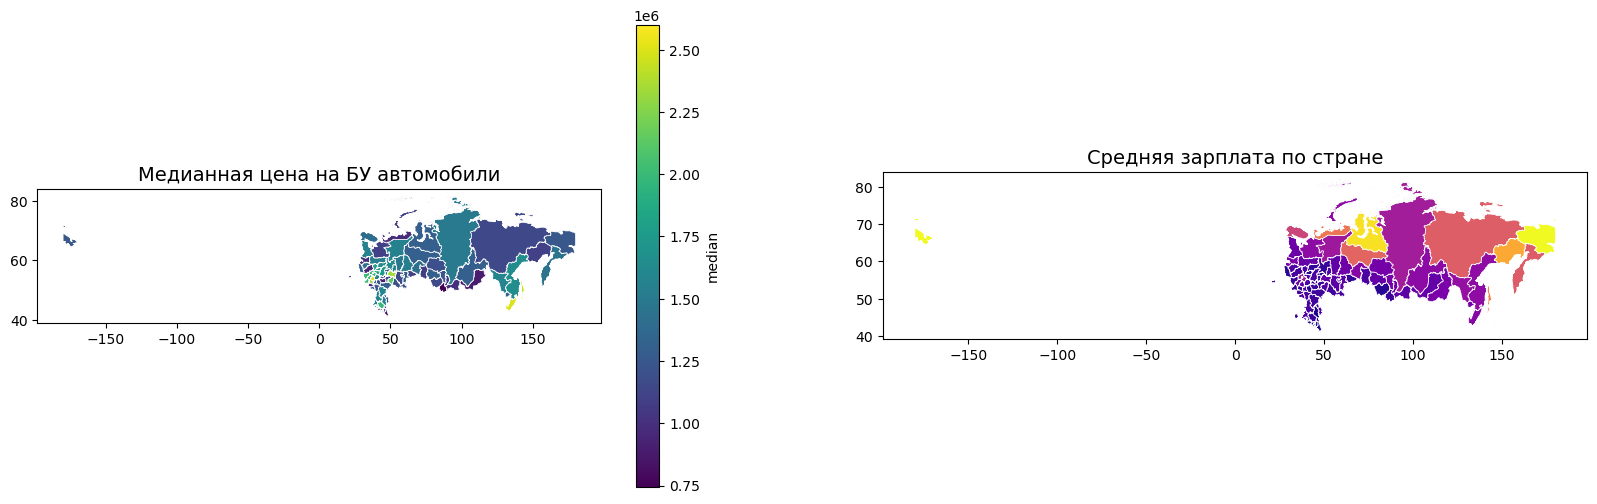

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

plot_auto_geo(data=df[df.flg_new_auto == 0],
              geo_data=russia_salary_geo,
              title='Медианная цена на БУ автомобили',
              cmap=colors[0],
              agg_col='price',
              func='median',
              group_col='NAME_1',
              ax=axes[0])

mo_gdf_wm = russia_salary_geo.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='median_salary',
               linewidth=0.5,
               cmap=colors[1],
               legend_kwds={
                   'label': "median salary",
                   'orientation': "vertical"
               },
               edgecolor="white",
               ax=axes[1],
               aspect='auto')
axes[1].set_title('Средняя зарплата по стране', fontdict={'fontsize': 14})
plt.show()

> Корреляции между стоимостью авто и заработком в регионах не наблюдается

### Кол-во новых автомобилей больше в регионах со средней ЗП выше средней по стране

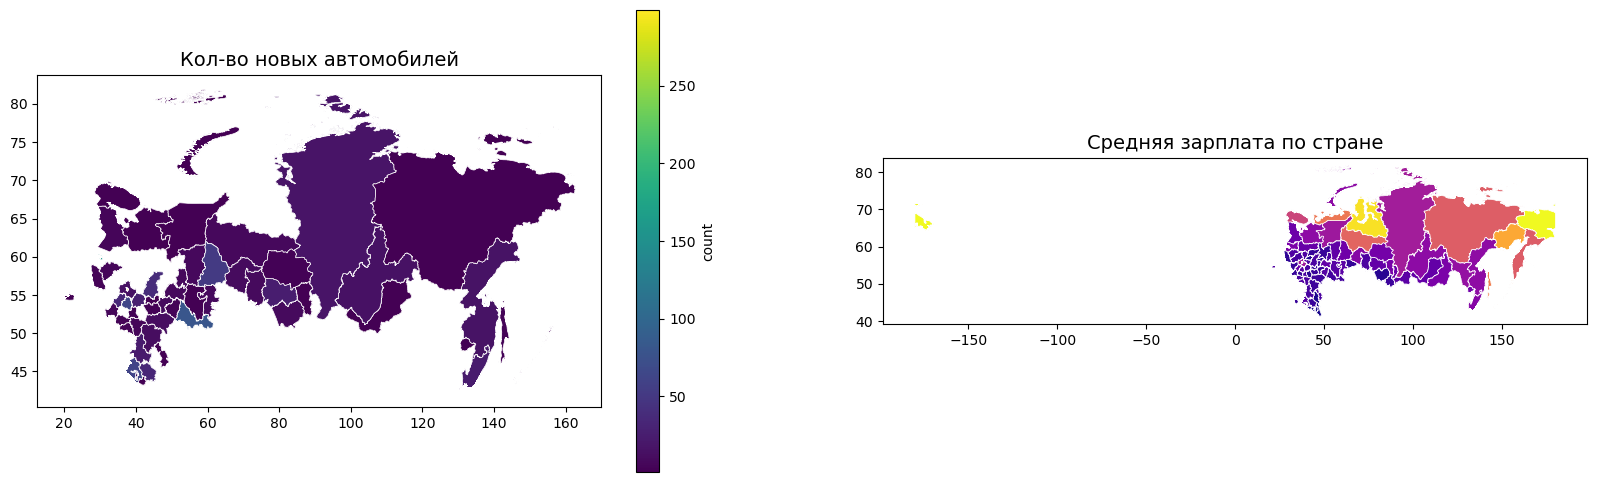

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

plot_auto_geo(data=df[df.flg_new_auto == 1],
              geo_data=russia_salary_geo,
              title='Кол-во новых автомобилей',
              cmap=colors[0],
              agg_col='price',
              func='count',
              group_col='NAME_1',
              ax=axes[0])

mo_gdf_wm = russia_salary_geo.to_crs({'init': 'epsg:4326'})
min_sal = russia_salary_geo.median_salary.min()
max_sal = russia_salary_geo.median_salary.max()
mo_gdf_wm.plot(column='median_salary',
               linewidth=0.5,
               cmap=colors[1],
               legend_kwds={
                   'label': "median salary",
                   'orientation': "vertical"
               },
               edgecolor="white",
               vmin=min_sal,
               vmax=max_sal,
               ax=axes[1],
               aspect='auto')
axes[1].set_title('Средняя зарплата по стране', fontdict={'fontsize': 14})
plt.show()

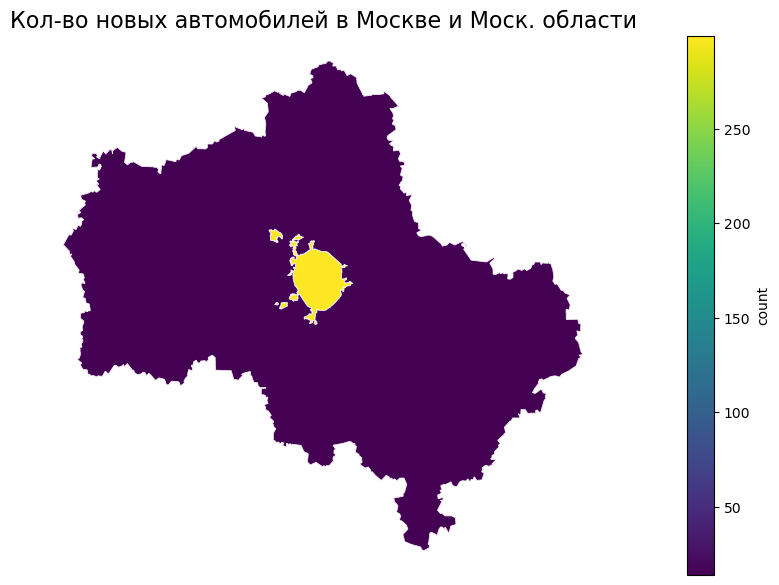

In [66]:
plot_auto_geo(data=df[(df.flg_new_auto == 1)
                      & (df.region.str.contains('Моск'))],
              geo_data=russia_salary_geo,
              title='Кол-во новых автомобилей в Москве и Моск. области',
              cmap=colors[0],
              agg_col='price',
              func='count',
              group_col='NAME_1')

### Влияние типа кузова на цену

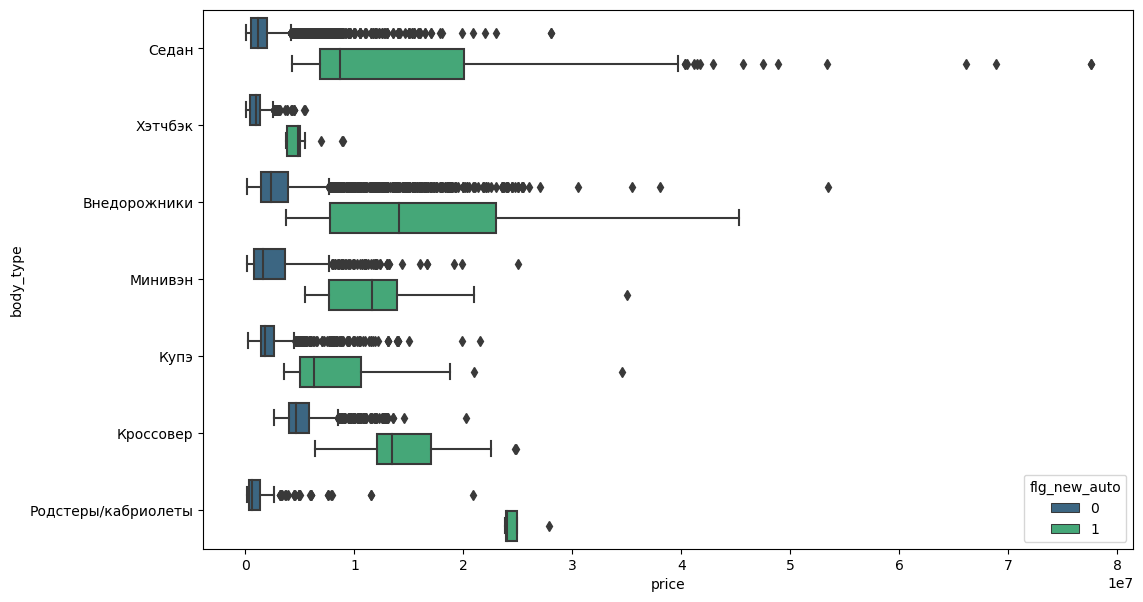

In [67]:
plt.figure(figsize=(12, 7))

sns.boxplot(data=df,
           x='price',
           hue='flg_new_auto',
            y='body_type',
           palette=colors[0],
           orient='h')
plt.show()

> Большой разброс у седанов и внедорожников, имеются примеальные модели.

> Родстеры и кабриолеты новые самы дорогие, но быстро дешевеют.

### Больше всего БУ авто в Центральном регионе страны

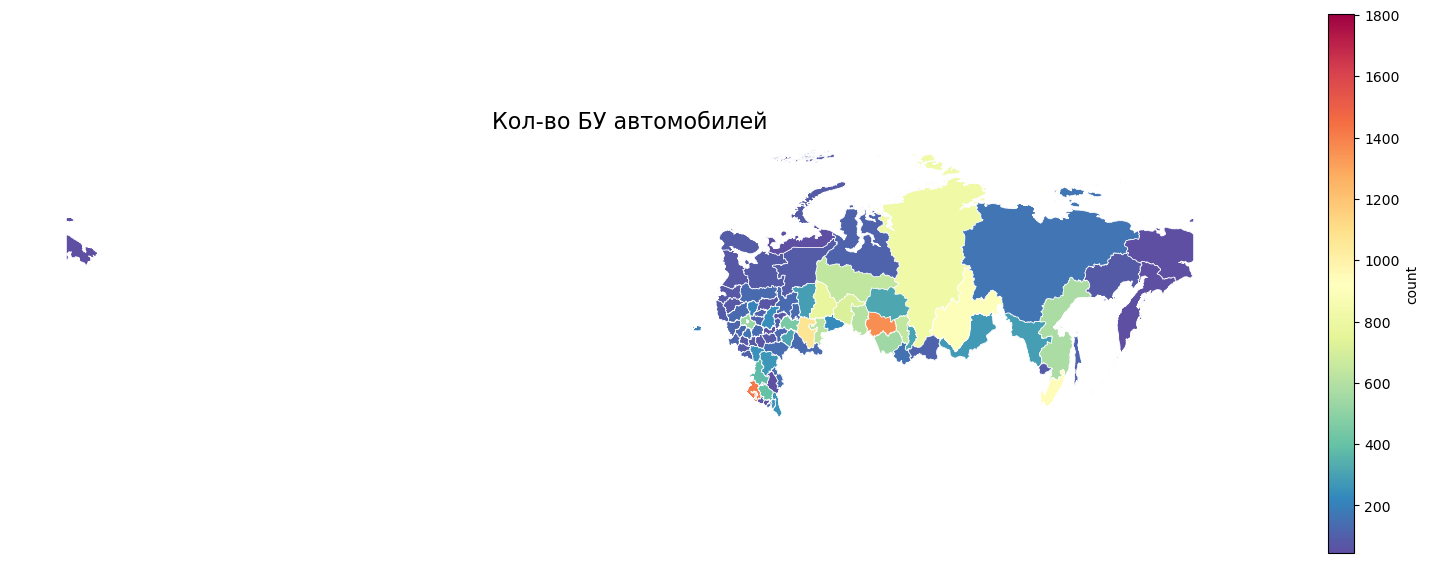

In [68]:
plot_auto_geo(data=df[df.flg_new_auto == 0],
              geo_data=russia_salary_geo,
              title='Кол-во БУ автомобилей',
              agg_col='price',
              func='count',
              group_col='NAME_1')
plt.show()

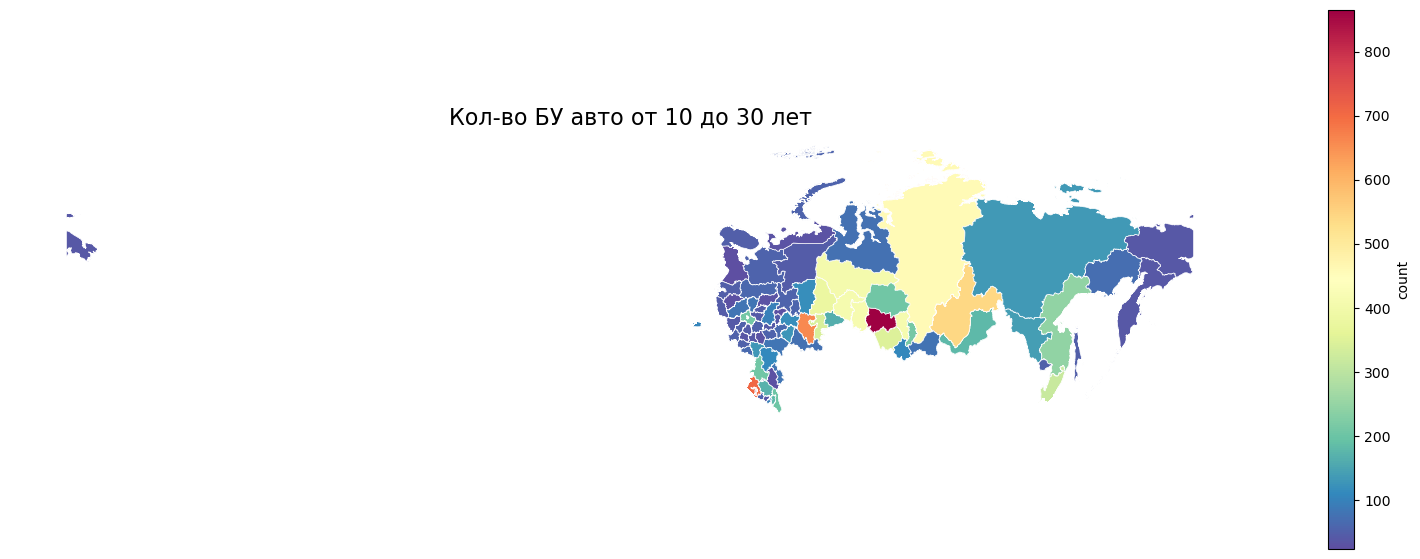

In [69]:
plot_auto_geo(data=df[(df.age > 10) & (df.age < 30)],
             geo_data=russia_salary_geo,
             title='Кол-во БУ авто от 10 до 30 лет',
             agg_col='price',
             func='count',
             group_col='NAME_1')
plt.show()

> Больше всего продается БУ авто в Москве, Астраханской области, Новосибирской области, а также Башкортостане

### Больше БУ авто в продаже, значит меньше цена

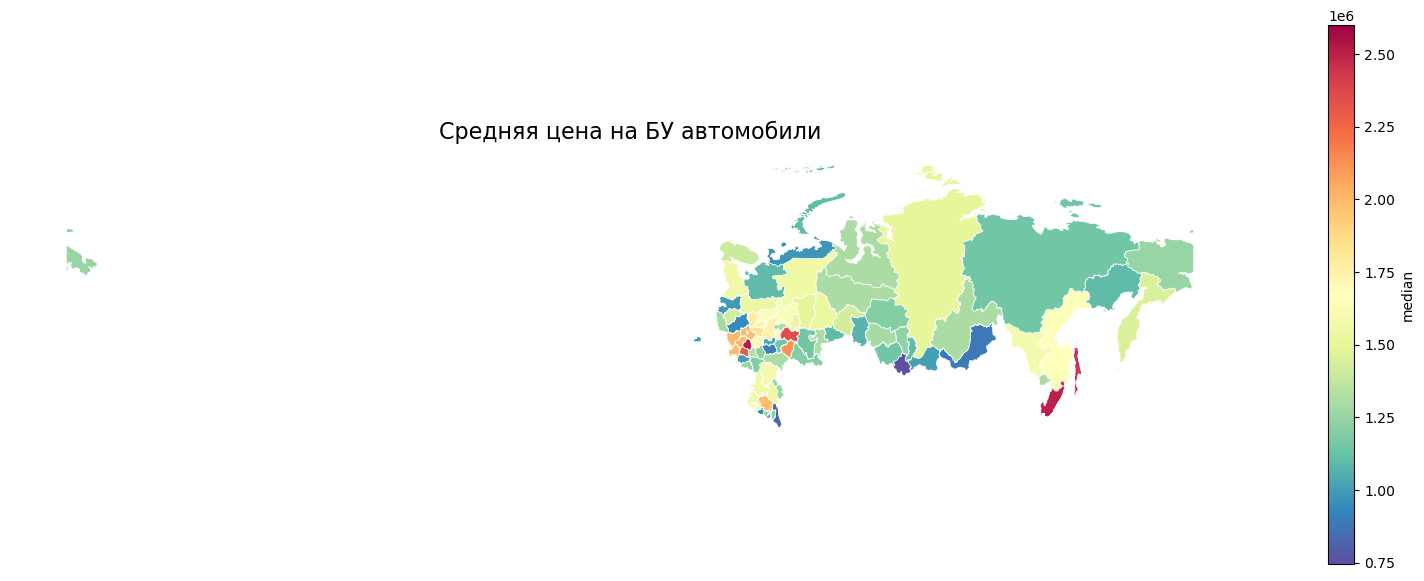

In [70]:
plot_auto_geo(data=df[df.flg_new_auto == 0],
              geo_data=russia_salary_geo,
              title='Средняя цена на БУ автомобили',
              agg_col='price',
              func='median',
              group_col='NAME_1')
plt.show()

### Дополнительно

Давайте посмотрим, насколько в % падают в цене автомобили по типу кузова

In [80]:
df_pivot_diff = df[df.flg_new_auto == 0].pivot_table(values='price',
                                                     index='body_type',
                                                     columns='age',
                                                     aggfunc='median')

df_pivot_diff = df_pivot_diff.iloc[:, :5].dropna()
df_pivot_diff['price_new_auto'] = df[df.flg_new_auto == 1].groupby(
    'body_type')['price'].median()

for i in range(5):
    df_pivot_diff[f'diff_{i+1}_year'] = (df_pivot_diff['price_new_auto'] - df_pivot_diff[i+1]) / df_pivot_diff['price_new_auto']

In [82]:
df_pivot_diff

age,1,2,3,4,5,price_new_auto,diff_1_year,diff_2_year,diff_3_year,diff_4_year,diff_5_year
body_type,,,,,,,,,,,
Внедорожники,11450000.0,6744999.5,5500000.0,5245000.0,3620000.0,14081242.0,0.186861,0.520994,0.609409,0.627519,0.742920
Кроссовер,10869000.0,10800000.0,8200000.0,4502500.0,4700000.0,13490000.0,0.194292,0.199407,0.392142,0.666234,0.651594
Купэ,4200000.0,4670000.0,3400000.0,2849000.0,3100000.0,6248000.0,0.327785,0.252561,0.455826,0.544014,0.503841
Минивэн,6500000.0,10800000.0,6900000.0,5750000.0,4099000.0,11580000.0,0.438687,0.067358,0.404145,0.503454,0.646028
Седан,7125000.0,6000000.0,4097000.0,3350000.0,3050000.0,8680000.0,0.179147,0.308756,0.527995,0.614055,0.648618


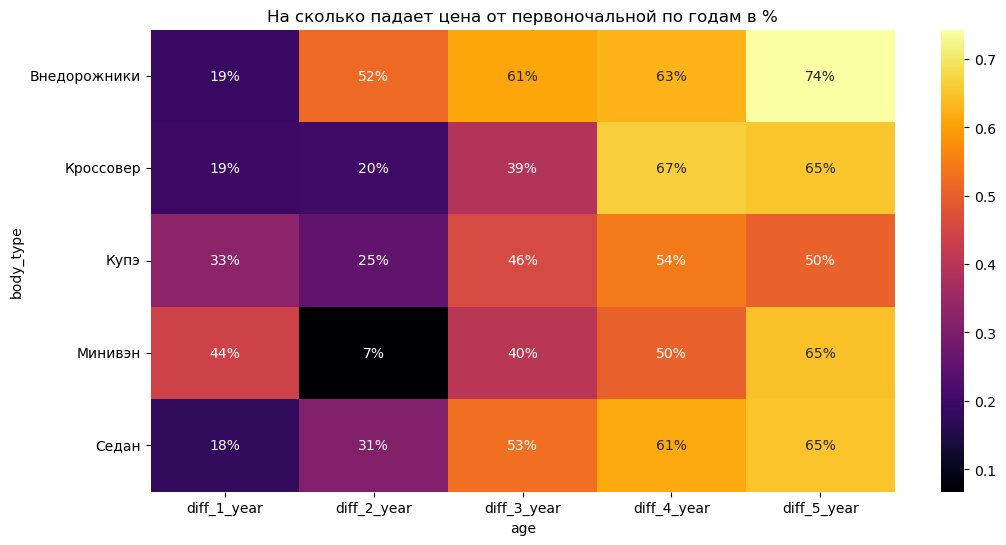

In [84]:
plt.figure(figsize=(12, 6))

ax = sns.heatmap(df_pivot_diff.loc[:, 'diff_1_year':],
                cmap=colors[2],
                annot=True,
                fmt='.0%')
plt.title('На сколько падает цена от первоночальной по годам в %')
plt.show()

> Самое большое падение цены наблюдается у минивэнов, а также у купэ

> Начиная со 2го года эксплуатации в цене сильно падают внедорожники

### Проанализируем, какие типы кузова чаще всего покупают в тех или иных регионах

In [85]:
# Относительно всех автомобилей в регионе
# считаем кол-во каждого типа кузова в регионах
df_count_region = df.pivot_table(values='price',
                                 index='body_type',
                                 columns='region',
                                 aggfunc='count').fillna(0)
# нормируем на кол-во машин в регионе
df_norm_region = df_count_region / df.groupby('region').count().iloc[:, 0]
df_max_region = df_norm_region.idxmax().reset_index().rename(
    columns={0: 'body_type'})

# объединяем с гео данными
gpd_region_max = gpd.GeoDataFrame(
    pd.merge(russia_salary_geo, df_max_region, how='inner', on='region'))

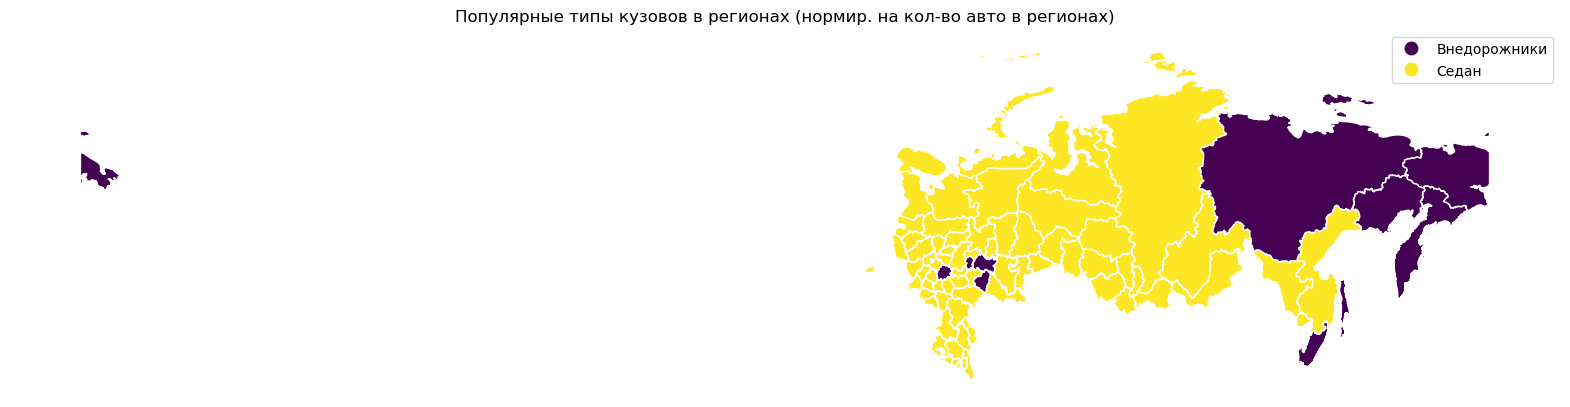

In [86]:
colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

mo_gdf_wm = gpd_region_max.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[0],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во авто в регионах)')
plt.axis('off')
plt.show()

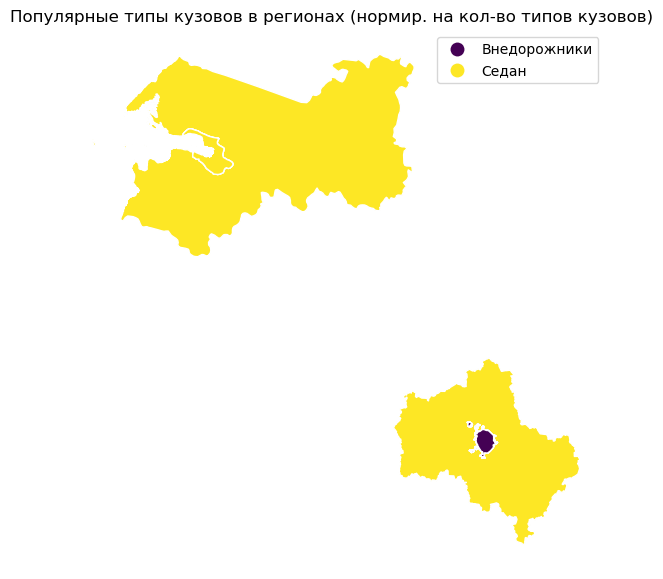

In [87]:
searchfor = ['Санкт', 'Лен', 'Моск']
mo_gdf_wm = gpd_region_max[gpd_region_max.region.str.contains(
    '|'.join(searchfor))].to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[0],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во типов кузовов)')
plt.axis('off')
plt.show()

In [88]:
# Относительно кол-ва продаваемых типов кузовов
# нормируем на кол-во типов кузовов
df_norm_region = df_count_region.T / df.groupby('body_type').count().iloc[:, 0]
df_max_region = df_norm_region.T.idxmax().reset_index().rename(
    columns={0: 'body_type'})

# объединяем с гео данными
gpd_body_max = gpd.GeoDataFrame(
    pd.merge(russia_salary_geo, df_max_region, how='inner', on='region'))

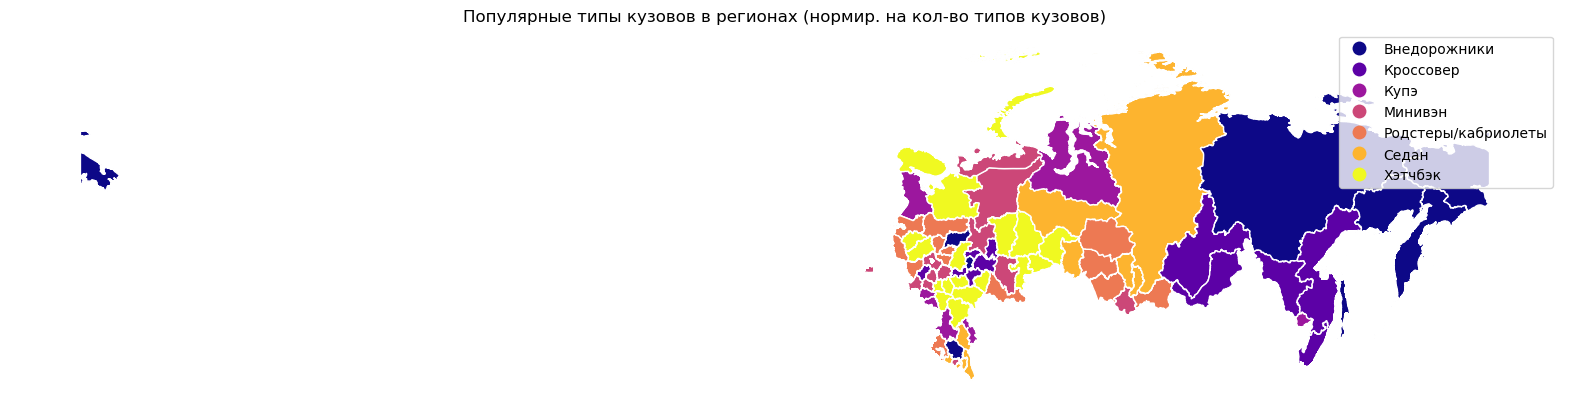

In [89]:
colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

mo_gdf_wm = gpd_body_max.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[1],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во типов кузовов)')
plt.axis('off')
plt.show()

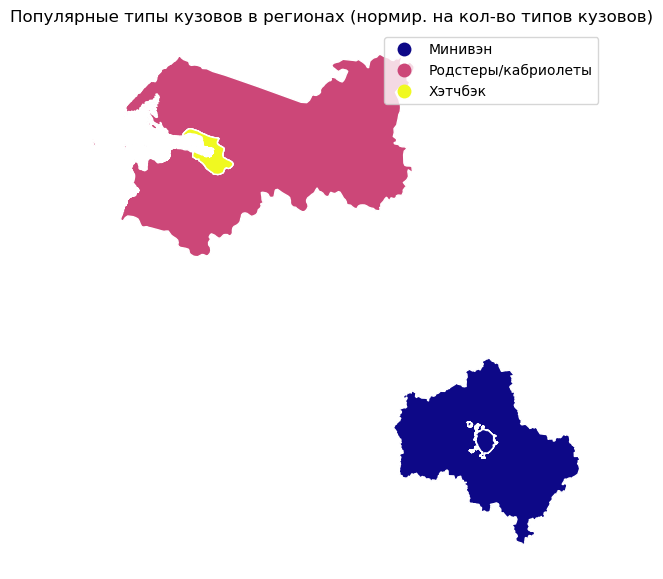

In [90]:
searchfor = ['Санкт', 'Лен', 'Моск']
mo_gdf_wm = gpd_body_max[gpd_body_max.region.str.contains(
    '|'.join(searchfor))].to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[1],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во типов кузовов)')
plt.axis('off')
plt.show()

> Внедорожники все также популярны на востоке страны

> В Москве также предпочитают больше минивэны, в Санкт-Петербурге - хэтчбеки

In [92]:
df.to_csv(os.path.join('data/clean_full_dataset.csv'), index=0)